## Introduction
Predicting customer car category preference using Multinomial Logistic Regression.
**Multinomial Logistic Regression**.

In [16]:
#  Load Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline



## Load Dataset

In [17]:
# Load the dataset
df = pd.read_csv(r'../data/processed/Car_Sales_Clean.csv')
df.head()

,car_id,purchase_date,customer_name,gender,annual_income,dealer_name,company,model,engine,transmission,color,price,dealer_no,body_style,phone,dealer_region
0,C_CND_000001,1/2/2022,Geraldine,Male,13500,Buddy Storbeck's Diesel Service Inc,Ford,Expedition,Double Overhead Camshaft,Auto,Black,26000,06457-3834,SUV,8264678,Middletown
1,C_CND_000002,1/2/2022,Gia,Male,1480000,C & M Motors Inc,Dodge,Durango,Double Overhead Camshaft,Auto,Black,19000,60504-7114,SUV,6848189,Aurora
2,C_CND_000003,1/2/2022,Gianna,Male,1035000,Capitol KIA,Cadillac,Eldorado,Overhead Camshaft,Manual,Red,31500,38701-8047,Passenger,7298798,Greenville
3,C_CND_000004,1/2/2022,Giselle,Male,13500,Chrysler of Tri-Cities,Toyota,Celica,Overhead Camshaft,Manual,Pale White,14000,99301-3882,SUV,6257557,Pasco
4,C_CND_000005,1/2/2022,Grace,Male,1465000,Chrysler Plymouth,Acura,TL,Double Overhead Camshaft,Auto,Red,24500,53546-9427,Hatchback,7081483,Janesville


## Clean Column Names


In [18]:
# Clean column names for easier access
df.columns = df.columns.str.strip().str.replace(' ', '_').str.replace('[$()]', '', regex=True)
df.columns

Index(['car_id', 'purchase_date', 'customer_name', 'gender', 'annual_income',
       'dealer_name', 'company', 'model', 'engine', 'transmission', 'color',
       'price', 'dealer_no', 'body_style', 'phone', 'dealer_region'],
      dtype='object')

## Define Target 

In [19]:
# Define target variable
y = df['body_style']

# Select features for input
selected_cols = ['gender', 'annual_income', 'dealer_region', 'company', 'engine', 'transmission', 'price']
X = df[selected_cols]

## Encode Categorical Features

In [20]:
# Define categorical and numerical columns
categorical_cols = ['gender', 'dealer_region', 'company', 'engine', 'transmission']
numerical_cols = ['annual_income', 'price']

# Create column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols)
    ])

# Apply the transformer and split data
X_processed = preprocessor.fit_transform(X)
X_processed.shape

(23906, 40)

## Train-Test Split

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, stratify=y, random_state=42)

## Train the Logitstic Regression Model

In [22]:
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, multi_class='multinomial')

## Evaluate the Model


              precision    recall  f1-score   support

     Hardtop       0.54      0.08      0.14       594
   Hatchback       0.35      0.40      0.37      1226
   Passenger       0.43      0.18      0.26       789
         SUV       0.38      0.62      0.47      1275
       Sedan       0.44      0.45      0.45       898

    accuracy                           0.39      4782
   macro avg       0.43      0.34      0.34      4782
weighted avg       0.41      0.39      0.36      4782



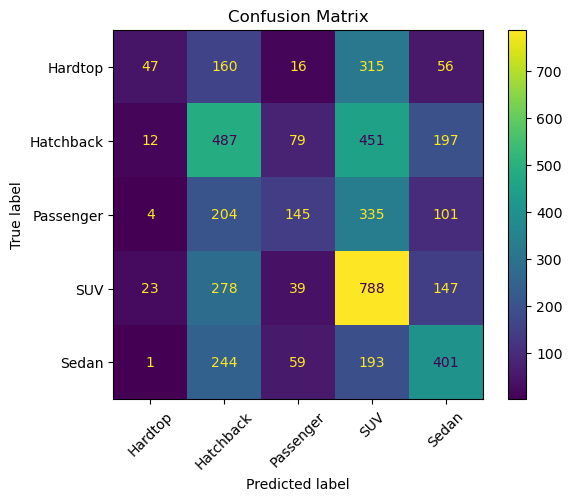

In [23]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

In [24]:
car_categories = model.classes_

# getting data for actual trend
actual_values = cm.sum(axis=1)

# getting data for the predicted trend
predicted_values = cm.sum(axis=0)

car_sales_actual = pd.DataFrame({'Car Category': car_categories, 'Value': actual_values, 'Source': 'Actual'})
car_sales_actual = car_sales_actual.sort_values('Value', ascending=False)
car_sales_actual

,Car Category,Value,Source
3,SUV,1275,Actual
1,Hatchback,1226,Actual
4,Sedan,898,Actual
2,Passenger,789,Actual
0,Hardtop,594,Actual


In [25]:
car_sales_predicted = pd.DataFrame({'Car Category': car_categories, 'Value': predicted_values, 'Source': 'Predicted'})
car_sales_predicted = car_sales_predicted.sort_values('Value', ascending=False)
car_sales_predicted

,Car Category,Value,Source
3,SUV,2082,Predicted
1,Hatchback,1373,Predicted
4,Sedan,902,Predicted
2,Passenger,338,Predicted
0,Hardtop,87,Predicted


In [26]:
import plotly.express as px

car_sales_combo = pd.concat([car_sales_actual, car_sales_predicted], ignore_index=True)
fig = px.bar(
    car_sales_combo,
    x='Car Category',
    y='Value',
    color='Source',
    barmode='group',
    color_discrete_map={'Actual': '#5775CF', 'Predicted': '#95CF57'},
    text='Value'
)
fig.update_layout(
    width=900,
    height=500,
    title=dict(
        text='Car Category Popularity: Actual Purchases vs Predicted Purchases',
        x=0.5,
        xanchor='center'
    ),
    xaxis_title='Car Category',
    yaxis_title='Value',
    bargap=0.2,
    plot_bgcolor='white',
    font=dict(size=14),
    legend=dict(
        title='Legend',
        orientation='v',
        x=1.05,
        y=1
    ),
    #xaxis=dict(
        #showgrid=True,
        #gridcolor='lightgray',
        #gridwidth=1
    #),
    yaxis=dict(
        showgrid=True,
        gridcolor='lightgray',
        gridwidth=1
    )
)

fig.update_traces(
    textposition='outside',
    textfont_size=12
)
fig.show()

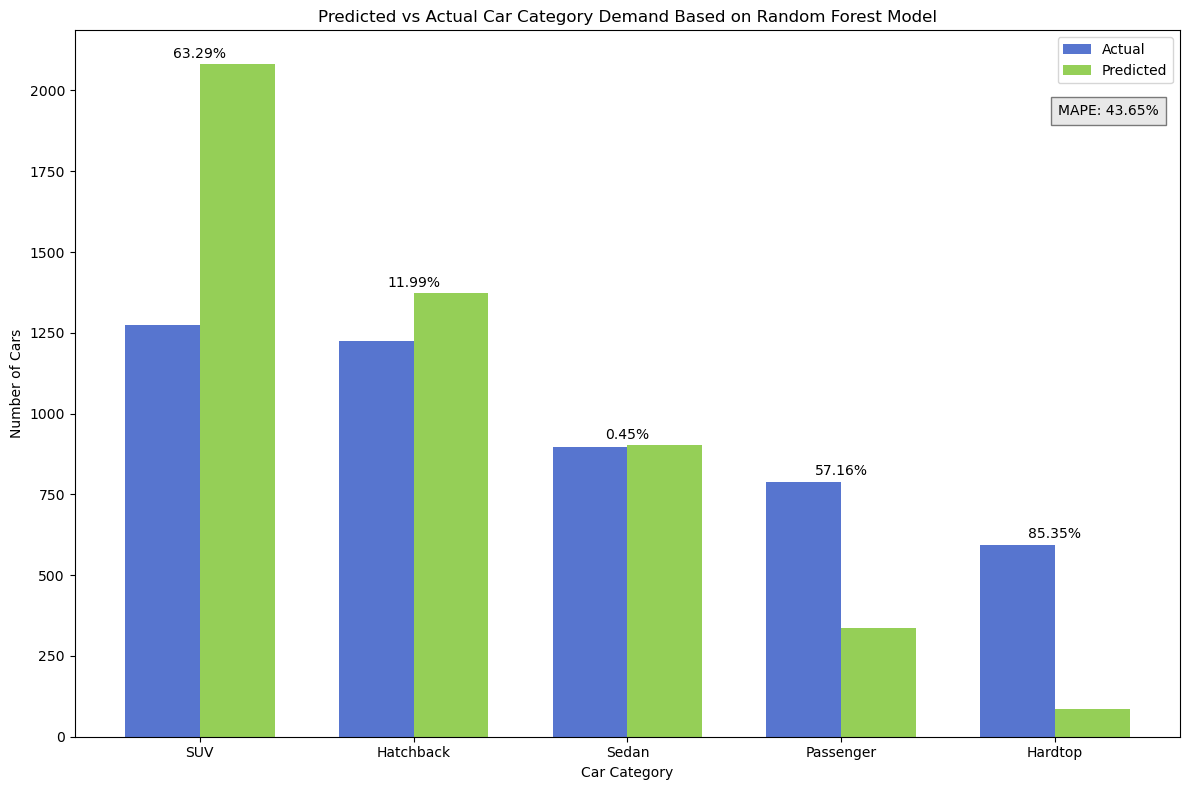

In [29]:
import numpy as np
category = car_sales_predicted['Car Category'].values
predicted = car_sales_predicted['Value'].values
actual = car_sales_actual['Value'].values
percent_error = [abs(p - a) / a * 100 for p, a in zip(predicted, actual)]
mape = np.mean(percent_error)

mape_summary = pd.DataFrame({
    'Car Category': car_categories,
    'Predicted': predicted,
    'Actual': actual,
    '% Error': percent_error
})

fig, ax1 = plt.subplots(figsize=(12, 8))
x = np.arange(len(category))
width = 0.35
ax1.bar(x - width/2, mape_summary['Actual'], width, label='Actual', color='#5775CF')
ax1.bar(x + width/2, mape_summary['Predicted'], width, label='Predicted', color='#95CF57')
ax1.set_ylabel('Number of Cars')
ax1.set_xlabel('Car Category')
ax1.set_title('Predicted vs Actual Car Category Demand Based on Random Forest Model')
ax1.set_xticks(x)
ax1.set_xticklabels(category)
ax1.legend(loc='upper right')
for i in range(len(category)):
    max_val = max(actual[i], predicted[i])
    ax1.text(x[i], max_val + 20, f"{percent_error[i]:.2f}%", ha='center', fontsize=10, color='black')

plt.figtext(0.97, 0.85, f"MAPE: {mape:.2f}%", horizontalalignment='right', fontsize=10,
            bbox={"facecolor":"lightgray", "alpha":0.5, "pad":5})

plt.tight_layout()
plt.show()

## Conclusion
### Best Predicted Category: SUV
Precision: 0.38

Recall: 0.62

F1 Score: 0.47
        Meaning: The model correctly identified 62% of actual SUV buyers and did so with reasonable precision. This category had the highest performance.

### Weakest Category: Hardtop
Precision: 0.54 (somewhat precise)

Recall: 0.08 (very low)

F1 Score: 0.14
     Meaning: Even when the model predicts "Hardtop," it’s rarely correct — and it misses most actual Hardtop buyers.

### Other Classes:
Hatchback and Sedan had moderate results (F1 around 0.38–0.45)

Passenger cars were poorly predicted, with low recall and F1 (suggests overlap with other classes)

### Overall Performance:
Accuracy: 39%

Macro F1 Score: 0.34

Weighted F1 Score: 0.36
     Conclusion: The model performs better than random guessing, but not strong enough for deployment.